In [1]:
import os
from datetime import datetime
# Make logging folder named according to current time
start_time_str = datetime.today().strftime('%d_%m_%Y__%H_%M_%S')
log_dir = './logs/'f"log_{start_time_str}"
os.makedirs(log_dir)

# Initialize logger that adds to text file in current logging folder
from logging_utils import *


# Initialize logger that adds to text file in current logging folder
from logging_utils import *
init_logger(save_dir=log_dir)
logger = get_logger()

In [2]:
import pathlib
import subprocess
# Get the absolute path to your repository, 
# no matter where you are running this code from

repo_path = os.getcwd() 


git_branch = subprocess.check_output(
    ["git", "-C", repo_path, "rev-parse", "--abbrev-ref", "HEAD"]).strip().decode('UTF-8')

git_commit_short_hash = subprocess.check_output(
    ["git", "-C", repo_path, "describe", "--always"]).strip().decode('UTF-8')


In [16]:
from src_dir import *
import numpy as np

dim=40


x0=np.squeeze(np.zeros((dim,dim)))
x0Type='Zero Solution 2D'

A=mk_laplace_2d(dim,dim)
AType='2D Laplacian'

retrain_freq=1
e1 = 1e-5
e2 = 1e-7
nmax_iter =int(dim/5)
restart   = 64

# sigma=0.02
sigma=0.2


DomainL=-1.0
DomainR=1.0

x1=np.linspace(DomainL,DomainR,dim)
x2=np.linspace(DomainL,DomainR,dim)
X, Y = np.meshgrid(x1, x2, sparse=False, indexing='ij')

n_steps =1000
InputDim=dim
HiddenDim=dim
OutputDim=dim

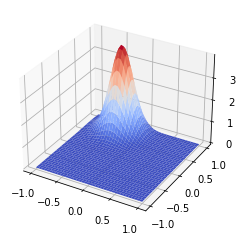

In [17]:
# check 2d grid and RHS

import matplotlib.pyplot as pp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = pp.figure()
ax = fig.add_subplot(111, projection='3d')
ProbIdx=30

# Z=np.sin(1)*X+np.cos(1)*Y

# xloc=np.cos(6*ProbIdx)*np.cos(ProbIdx)
# yloc=np.cos(6*ProbIdx)*np.sin(ProbIdx)
xloc=np.random.uniform(-1,1)
yloc=np.random.uniform(-1,1)
Z=Gauss_pdf_2D(X,Y,xloc,yloc,sigma)

# Z=np.maximum(2*X*np.sin(ProbIdx),2*Y*np.cos(ProbIdx))

ax.plot_surface(X,Y,Z,cmap=cm.coolwarm)

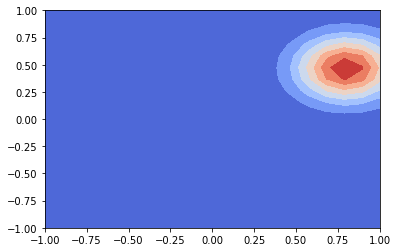

In [5]:
pp.contourf(X,Y,Z,cmap=cm.coolwarm)

In [18]:
# Initial log message
logger.info("5 Layer convnet. Add dilation to layers. Dim is 40")
#  The source is a narrow gaussian that depends on the integer 'time' in a nonlinear way. The gaussian is on the interval [-5,5], and constrained to move on [-3,3]. ")



# Set up parameter class
class MyParamsClass():
    def __init__(self, AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash):
        self.AType = AType
        self.dim = dim
        self.nmax_iter = nmax_iter
        self.restart = restart
        self.n_steps =n_steps
        self.retrain_freq=retrain_freq
        self.e1=e1
        self.e2=e2
        self.x0Type=x0Type
        self.InputDim=InputDim
        self.HiddenDim=HiddenDim
        self.OutputDim=OutputDim
        self.sigma=sigma
        self.DomainL=DomainL
        self.DomainR=DomainR
        self.git_branch=git_branch
        self.git_commit_short_hash=git_commit_short_hash





import os
import json

params = MyParamsClass(AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash)
sorted_params_dict = {k: params.__dict__[k] for k 
                      in sorted(params.__dict__.keys())}

params_filepath = log_dir+'/params.json'
json.dump(sorted_params_dict, open(params_filepath, 'w'), indent=4)

2020-10-07 21:08:14 [INFO] <ipython-input-18-46978cc0f4eb> 2 - 5 Layer convnet. Add dilation to layers. Dim is 40


In [20]:
from src_dir import *

@timer
@cnn_preconditionerOnline_timed_2D(retrain_freq,debug=True,InputDim=InputDim,HiddenDim=HiddenDim,OutputDim=OutputDim)
def MLGMRES(A, b ,x0, e, nmax_iter,ML_GMRES_Time_list,ProbCount,restart,debug,refine,blist,reslist,Err_list,reslist_flat,ML_GMRES_Time_list2,solIndx):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

In [21]:
from src_dir import *



ML_GMRES_Time_list=[]
ML_GMRES_Time_list2=[]

Err_list=[]
NonML_Err_List=[]

run_time_ML_list=[]
run_timeP1_ML_list=[]
run_timeP2_ML_list=[]

run_time_list=[]
GmresRunTimeOriginal=[]
GmresRunTimeOriginal2=[]
SpeedUp=[]


trainTime_list=[]


debug=True
refine1=False
refine2=True

blist=[]
reslist=[]
reslist_flat=[]

solIndx=0

for ProbIdx in range(n_steps):


    xloc=np.random.uniform(-1,1)
    yloc=np.random.uniform(-1,1)
    b=Gauss_pdf_2D(X,Y,xloc,yloc,sigma)
    b_flat=np.reshape(b,(1,-1),order='F').squeeze(0)
    b_norm=np.linalg.norm(b_flat)


    OutList1,run_time1_ML=MLGMRES(A, b/b_norm, x0, e1, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine1,blist,reslist,Err_list,reslist_flat,ML_GMRES_Time_list2,solIndx)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    ML_GMRES_Time_list=OutList1[1]
    blist=OutList1[3]
    reslist=OutList1[4]
    Err_list=OutList1[5]
    reslist_flat=OutList1[6]

    OutList2,run_time2_ML=MLGMRES(A, b/b_norm,Out[-1], e2, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine2,blist,reslist,Err_list,reslist_flat,ML_GMRES_Time_list2,solIndx)
    Out2=OutList2[0]
    ML_GMRES_Time_list=OutList2[1]
    trainTime_list.append(OutList2[2])
    blist=OutList2[3]
    reslist=OutList2[4]
    Err_list=OutList2[5]
    reslist_flat=OutList2[6]
    ML_GMRES_Time_list2=OutList2[7]
    solIndx=OutList2[8]

    run_timeP1_ML_list.append(run_time1_ML)
    run_timeP2_ML_list.append(run_time2_ML)
    run_time_ML_list.append(run_time1_ML+run_time2_ML)
    



    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[5])
   
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    
    GmresRunTimeOriginal.append(run_time1)
    GmresRunTimeOriginal2.append(run_time2)
    run_time_list.append(run_time1+run_time2)
    MLGMRES_GMRES_ONLY=sum(ML_GMRES_Time_list2)+sum(ML_GMRES_Time_list)
    SpeedUp.append(run_time1/ML_GMRES_Time_list[-1])
    
    
    print(ProbIdx)
    print("Speed up:", SpeedUp[-1])

run_time=sum(run_time_list)
run_time_ML=sum(run_time_ML_list)
trainTime_total=sum(trainTime_list)


logger.info("Runtime of Non-decorated version is:")
logger.info(run_time)

logger.info("Runtime of MLGMRES decorator is:")
logger.info(run_time_ML)

logger.info("Runtime of MLGMRES (only GMRES time) is:")
logger.info(MLGMRES_GMRES_ONLY)


logger.info("Runtime of training (backprop) is:")
logger.info(trainTime_total)



0
Speed up: 0.9820921115895682
1
Speed up: 1.0112863523330062
Final loss: 0.5157631635665894
parameters 17449
Initial Training
2
Speed up: 0.9844609177214387
size 8
0.6657667205764519 0.7003339647433023
3.3315820999996504 3.58478877449852 2.039676526207899 0.6094473125909132
3.3315820999996504 3.58478877449852 2.039676526207899 0.6094473125909132
3
Speed up: 1.0349806165664552
size 8
0.6676285008487807 2.039676526207899
3.3592269210021186 3.512477519998356 2.0408660809329615 1.2913202733927682
3.3592269210021186 3.512477519998356 2.0408660809329615 1.2913202733927682
4
Speed up: 1.0053685884934873
size 8
0.6553024964682291 2.0408660809329615
3.393227808002848 3.46139398699961 2.0219082012511587 1.5411688759061661
3.393227808002848 3.46139398699961 2.0219082012511587 1.5411688759061661
5
Speed up: 1.000674870397357
size 8
0.8801702359730338 2.0408660809329615
3.712970600998233 3.3613456096682057 2.2849192760178614 2.0341502694640066
3.712970600998233 3.3613456096682057 2.284919276017861

3.157888088000618 3.1932488684798592 2.4513264965843846 1.9249207310489593
3.157888088000618 3.1932488684798592 2.4513264965843846 1.9249207310489593
38
Speed up: 1.057207957331674
size 8
0.6326082518716821 3.1745084437250406
3.4785264849997475 3.1795797475997825 2.18866759793977 1.9671550611968633
3.4785264849997475 3.1795797475997825 2.18866759793977 1.9671550611968633
39
Speed up: 1.0503057906150643
size 8
0.5157254967127161 3.1745084437250406
2.0974485560000176 3.1767441000798136 3.0073994976447187 1.992784885796354
2.0974485560000176 3.1767441000798136 3.0073994976447187 1.992784885796354
40
Speed up: 1.6464605337385694
size 8
0.5050627385353408 3.1745084437250406
2.9799929530017835 3.1180686635998427 3.1980425891616444 2.0574346050195684
2.9799929530017835 3.1180686635998427 3.1980425891616444 2.0574346050195684
41
Speed up: 1.1649203483864505
size 8
0.6470669126282755 3.1980425891616444
3.1052088220021687 3.0898795654799325 2.64229576856163 2.14205028292403
3.1052088220021687 3.

KeyboardInterrupt: 

In [9]:
import matplotlib.pyplot as pp
from src_dir import *

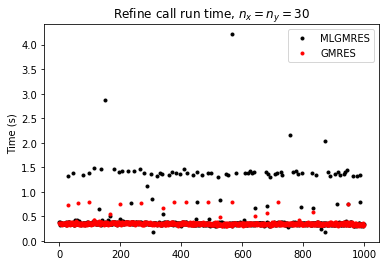

In [10]:
pp.plot(run_timeP2_ML_list,'.k',label='MLGMRES')
pp.plot(GmresRunTimeOriginal2,'.r',label='GMRES')
pp.title('Refine call run time, $n_x=n_y=30$')
pp.ylabel('Time (s)')
pp.legend(loc='best')
pp.savefig('EntireTime1.svg')

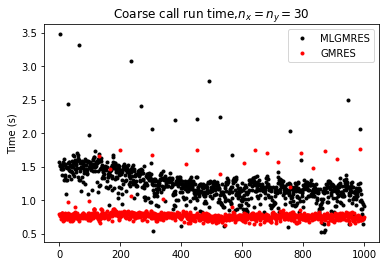

In [11]:
pp.plot(run_timeP1_ML_list,'.k',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r',label='GMRES')
pp.title('Coarse call run time,$n_x=n_y=30$')
pp.ylabel('Time (s)')
pp.legend(loc='best')
pp.savefig('EntireTime2.svg')

/global/cscratch1/sd/kluna1/GMRES-Learning/src_dir/util.py:68: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


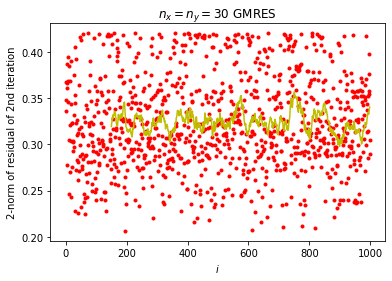

In [12]:
AVG=np.zeros((n_steps,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,n_steps)

for j in range(0,n_steps):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

    
    
pp.plot(count,np.asarray(NonML_Err_List),'.r',count[150:-1],AVG[150:-1],'y')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 2nd iteration')
pp.title('$n_x=n_y=30$ GMRES')
pp.savefig('GMRES.svg')

/global/cscratch1/sd/kluna1/GMRES-Learning/src_dir/util.py:68: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


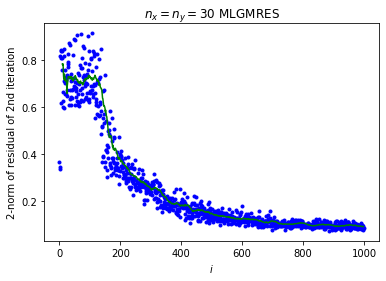

In [13]:
Err_Array_ML=np.asarray(Err_list)
AVGML=np.zeros((n_steps,1))

for j in range(0,n_steps):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)

pp.plot(count,np.asarray(Err_Array_ML),'.b',count[10:-1],AVGML[10:-1],'g')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 2nd iteration')
pp.title('$n_x=n_y=30$ MLGMRES')
pp.savefig('MLGMRES.svg')

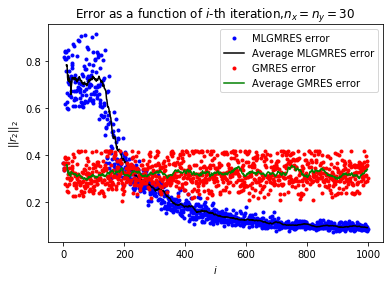

In [14]:
pp.plot(count,Err_Array_ML,'.b',label='MLGMRES error')
pp.plot(count[10:-1],AVGML[10:-1],'k',label='Average MLGMRES error')
pp.plot(count,Err_Array,'.r',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'g',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('$||r_2||_2$')
pp.title('Error as a function of $i$-th iteration,$n_x=n_y=30$ ')
pp.legend(loc='best')
pp.savefig('Compare.svg')

/global/cscratch1/sd/kluna1/GMRES-Learning/src_dir/util.py:68: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


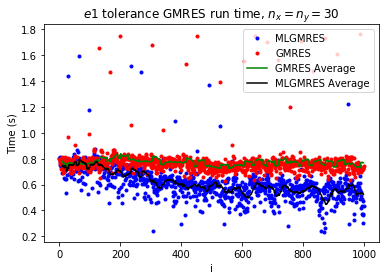

In [15]:
GmresRunTimeOriginal_AVG=np.zeros((n_steps,1))
ML_GMRES_Time_AVG=np.zeros((n_steps,1))


for j in range(0,n_steps):
    GmresRunTimeOriginal_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time_AVG[10:-1],'k', label='MLGMRES Average')

pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e1$ tolerance GMRES run time, $n_x=n_y=30$')
pp.legend(loc='best')
pp.savefig('Runtime1.svg')

/global/cscratch1/sd/kluna1/GMRES-Learning/src_dir/util.py:68: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


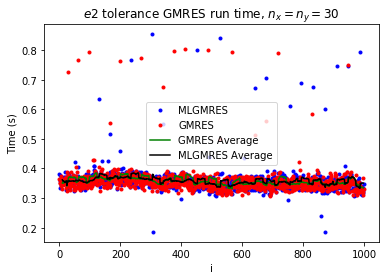

In [16]:
GmresRunTimeOriginal2_AVG=np.zeros((n_steps,1))
ML_GMRES_Time2_AVG=np.zeros((n_steps,1))
count=np.arange(0,n_steps)


for j in range(0,n_steps):
    GmresRunTimeOriginal2_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal2[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time2_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list2[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list2,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal2,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal2_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time2_AVG[10:-1],'k', label='MLGMRES Average')

pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e2$ tolerance GMRES run time, $n_x=n_y=30$')
pp.legend(loc='best')
pp.savefig('Runtime2.svg')

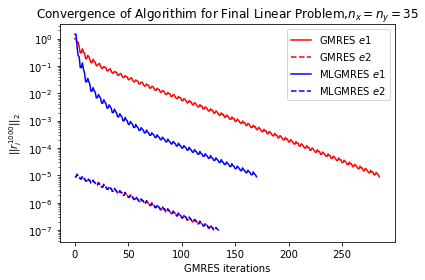

In [17]:
ML_Err=resid(A, Out, b/b_norm)
ML_Err2=resid(A, Out2, b/b_norm)
NonML_Err=resid(A, NonML_Out1, b/b_norm)
NonML_Err2=resid(A, NonML_Out2, b/b_norm)

pp.semilogy(NonML_Err,'r',label='GMRES $e1$')
pp.semilogy(NonML_Err2,'--r',label='GMRES $e2$')
pp.semilogy(ML_Err,'b',label='MLGMRES $e1$')
pp.semilogy(ML_Err2,'--b',label='MLGMRES $e2$')
pp.legend(loc='best')
pp.xlabel('GMRES iterations')
pp.ylabel('$||r^{1000}_{i}||_2$')
pp.title('Convergence of Algorithim for Final Linear Problem,$n_x=n_y=35$')
pp.savefig('Error.svg')

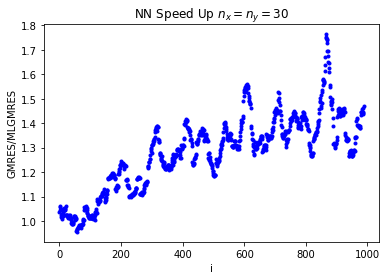

In [18]:
GMRESAVG=GmresRunTimeOriginal_AVG[10:-1]
MLGMRESAVG=ML_GMRES_Time_AVG[10:-1]
Ratio=np.divide(GMRESAVG,MLGMRESAVG)



pp.plot(Ratio,'.b')
pp.xlabel('i')
pp.ylabel('GMRES/MLGMRES')
pp.title("NN Speed Up $n_x=n_y=30$ ")
pp.savefig('SpeedUp.svg')

Text(0.5, 1.0, 'Error Ratio $n_x=n_y=30$ ')

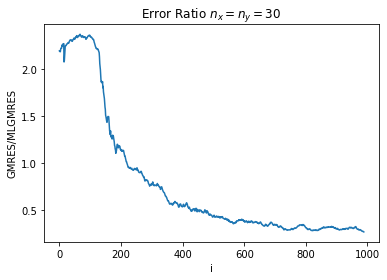

In [19]:
MLError_AVG=AVGML[10:-1]
Error_AVG=AVG[10:-1]
Ratio=np.divide(MLError_AVG,Error_AVG)



pp.plot(Ratio)
pp.xlabel('i')
pp.ylabel('GMRES/MLGMRES')
pp.title("Error Ratio $n_x=n_y=30$ ")

In [20]:
Err_Array=np.expand_dims(np.asarray(NonML_Err_List),axis=1)
Err_Array_ML=np.expand_dims(np.asarray(Err_list),axis=1)
GmresTime1Arr=np.expand_dims(np.asarray(GmresRunTimeOriginal),axis=1)
MLGmresTime1Arr=np.expand_dims(np.asarray(ML_GMRES_Time_list),axis=1)
GmresTime2Arr=np.expand_dims(np.asarray(GmresRunTimeOriginal2),axis=1)
MLGmresTime2Arr=np.expand_dims(np.asarray(ML_GMRES_Time_list2),axis=1)

WriteDataArr=np.concatenate((Err_Array_ML,Err_Array,GmresTime1Arr,MLGmresTime1Arr,GmresTime2Arr,MLGmresTime2Arr),axis=1)
np.savetxt('PerformanceData.txt',WriteDataArr)

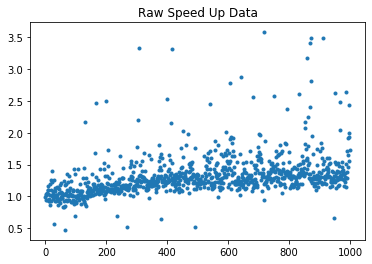

In [21]:
pp.plot(SpeedUp,'.')
pp.title("Raw Speed Up Data")
np.savetxt('SpeedUpData.txt',np.asarray(SpeedUp))